# Tutorial 8: Neurons with Voltage-gated Ion Channels

In [1]:
# Add the library to the path
# If jupyter cannot find SNS-Toolbox
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from sns_toolbox.neurons import NonSpikingNeuronWithGatedChannels, NonSpikingNeuronWithPersistentSodiumChannel
from sns_toolbox.connections import NonSpikingSynapse
from sns_toolbox.networks import Network
from sns_toolbox.renderer import render

import numpy as np
import matplotlib.pyplot as plt

In [3]:
def zinf(U, Kz, Sz, Ez):
    return 1/(1+Kz*np.exp(Sz*(Ez-U)))

def tauz(U, tauzmax, Kz, Sz, Ez):
    return tauzmax*zinf(U, Kz, Sz, Ez)*np.sqrt(Kz*np.exp(Sz*(Ez-U)))

Text(0.5, 1.0, 'TauZ')

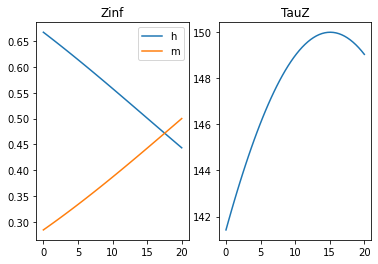

In [4]:
U = np.linspace(0,20)

Kh = 0.5
Sh = -0.046
Eh = 0
tauhmax = 300

Km = 1
Sm = 0.046
Em = 20

plt.figure()
plt.subplot(1,2,1)
plt.plot(U,zinf(U, Kh, Sh, Eh),label='h')
plt.plot(U,zinf(U, Km, Sm, Em),label='m')
plt.legend()
plt.title('Zinf')
plt.subplot(1,2,2)
plt.plot(U, tauz(U, tauhmax, Kh, Sh, Eh), label='h')
plt.title('TauZ')

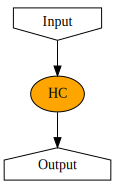

In [5]:
Cm = 5
Gm = 1
Ena = 50
Er = -60
delta = -0.01
R = 20

S = 0.05
delEna = Ena - Er
Km = 1
Kh = 0.5
Em = -40
Eh = -60
delEm = Em-Er
delEh = Eh-Er
tauHmax = 300

Gna = Gm*R/(zinf(R, Km, S, delEm)*zinf(R, Kh, -S, delEh)*(delEna-R))

g_ion = Gna
e_ion = delEna

pow_a = 1
k_a = Km
slope_a = S
e_a = delEm

pow_b = 1
k_b = Kh
slope_b = -S
e_b = delEh
tau_max_b = tauHmax

pow_c = 0
k_c = 1
slope_c = 0
e_c = 0
tau_max_c = 1

neuron_cpg = NonSpikingNeuronWithGatedChannels(membrane_capacitance=Cm, membrane_conductance=Gm,g_ion=[g_ion],e_ion=[e_ion],
                                               pow_a=[pow_a],k_a=[k_a],slope_a=[slope_a],e_a=[e_a],
                                               pow_b=[pow_b],k_b=[k_b],slope_b=[slope_b],e_b=[e_b],tau_max_b=[tau_max_b],
                                               pow_c=[pow_c],k_c=[k_c],slope_c=[slope_c],e_c=[e_c],tau_max_c=[tau_max_c],
                                               name='HC',color='orange')

net = Network()
net.add_neuron(neuron_cpg)
net.add_input(0)
net.add_output(0)

render(net)

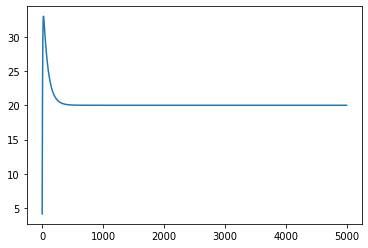

In [6]:
I = 0
tStart = 1000
tEnd = 4000

dt = 1
tMax = 5000

t = np.arange(0,tMax,dt)
numSteps = np.size(t)

Iapp = np.zeros(numSteps)
Iapp[tStart:tEnd] = I

Ipert = np.zeros(numSteps)
Ipert[1] = 1

model = net.compile(backend='numpy',dt=dt)
data = np.zeros([len(t), net.get_num_outputs_actual()])
inputs = Iapp + Ipert

for i in range(len(t)):
    data[i] = model([inputs[i]])
data = data.transpose()

plt.figure()
plt.plot(t,data[:][0])

plt.show()

In [7]:
def minf(U):
    return zinf(U, Km, S, delEm)

def hinf(U):
    return zinf(U, Kh, -S, delEh)

def cpg(delta=-0.01):
    Cm = 5
    Gm = 1
    Ena = 50
    Er = -60
    R = 20

    S = 0.05
    delEna = Ena - Er
    Km = 1
    Kh = 0.5
    Em = -40
    Eh = -60
    delEm = Em-Er
    delEh = Eh-Er
    tauHmax = 300

    Gna = Gm*R/(zinf(R, Km, S, delEm)*zinf(R, Kh, -S, delEh)*(delEna-R))

    g_ion = [Gna]
    e_ion = [delEna]

    pow_m = [1]
    k_m = [Km]
    slope_m = [S]
    e_m = [delEm]

    pow_h = [1]
    k_h = [Kh]
    slope_h = [-S]
    e_h = [delEh]
    tau_max_h = [tauHmax]

    neuron_cpg = NonSpikingNeuronWithPersistentSodiumChannel(membrane_capacitance=Cm, membrane_conductance=Gm,
                                                             g_ion=g_ion,e_ion=e_ion,
                                                             k_m=k_m,slope_m=slope_m,e_m=e_m,
                                                             k_h=k_h,slope_h=slope_h,e_h=e_h,tau_max_h=tau_max_h,
                                                             name='HC',color='orange')

    Ein = -100
    delEsyn = Ein-R
    
    gSyn = (-delta - delta*Gna*minf(delta)*hinf(delta) + Gna*minf(delta)*hinf(delta)*delEna)/(delta - delEsyn)
    
    synapse_cpg = NonSpikingSynapse(max_conductance=gSyn, reversal_potential=delEsyn)
    
    net = Network()
    net.add_neuron(neuron_cpg,name='HC0',color='blue')
    net.add_input('HC0')
    net.add_output('HC0')
    net.add_neuron(neuron_cpg,name='HC1',color='orange')
    net.add_output('HC1')
    net.add_connection(synapse_cpg,'HC0','HC1')
    net.add_connection(synapse_cpg,'HC1','HC0')
    
    I = 0
    tStart = 1000
    tEnd = 4000
    tTail = 2500

    dt = 1
    tMax = 5000

    t = np.arange(0,tMax,dt)
    numSteps = np.size(t)

    Iapp = np.zeros(numSteps)
    Iapp[tStart:tEnd] = I

    Ipert = np.zeros(numSteps)
    Ipert[1] = 1

    model = net.compile(backend='numpy',dt=dt)
    data = np.zeros([len(t), net.get_num_outputs_actual()])
    inputs = Iapp + Ipert

    for i in range(len(t)):
        data[i] = model([inputs[i]])
    data = data.transpose()

    render(net)
    return data

In [8]:
def plot_cpg(delta=-0.01):
    data = cpg(delta=delta)
    plt.plot(t,data[:][0],label='HC0',color='C0')
    plt.plot(t,data[:][1],label='HC1',color='C1',linestyle='--')
    plt.xlabel('t (ms)')
    plt.ylabel('U (mV)')
    plt.title('CPG')
    plt.legend()

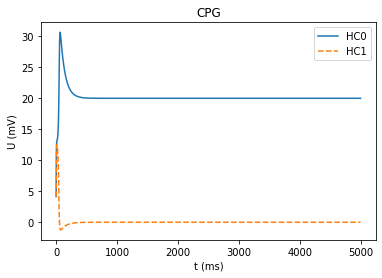

In [9]:
plot_cpg(delta=-0.01)

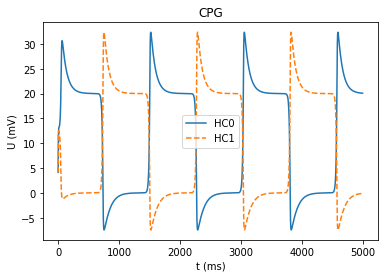

In [10]:
plot_cpg(delta=0.01)

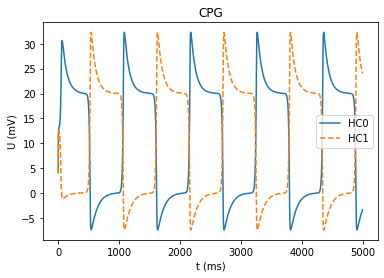

In [11]:
plot_cpg(delta=0.1)